In [116]:
import pandas as pd
import cv2
from matplotlib import pyplot as plt
import numpy as np

from sklearn.cluster import KMeans

In [117]:
data=pd.read_csv("result_interaction_atf.csv")
interaction_array=np.array(data['Interaction'])
interaction_with_array=np.array(data['Interact_with'])

In [118]:
data

,Id,x,y,Expression,Action,Gesture,Interaction,Interact_with
0,person1,182,80,Neutral,Sitting,Down,reading,book
1,person1,176,81,Neutral,Sitting,Down,reading,book
2,person1,174,82,Neutral,Sitting,Down,reading,book
3,person1,174,83,Neutral,Sitting,Down,reading,book
4,person1,173,84,Neutral,Sitting,Down,reading,book
...,...,...,...,...,...,...,...,...
151,person1,548,547,None,Sitting,Down,calling,phone
152,person1,558,543,None,Walking,Down,calling,phone
153,person1,556,555,None,Walking,Down,calling,phone
154,person1,549,548,None,Walking,Down,calling,phone


In [119]:
data2=data.loc[:,['x','y']]

In [120]:
data2

,x,y
0,182,80
1,176,81
2,174,82
3,174,83
4,173,84
...,...,...
151,548,547
152,558,543
153,556,555
154,549,548


In [121]:
data3 = [list(e) for e in zip(data['x'],data['y'])]

In [122]:
data3

[[182, 80],
 [176, 81],
 [174, 82],
 [174, 83],
 [173, 84],
 [173, 85],
 [166, 86],
 [158, 87],
 [159, 88],
 [169, 89],
 [187, 88],
 [195, 91],
 [205, 92],
 [217, 93],
 [235, 94],
 [248, 95],
 [258, 96],
 [265, 97],
 [274, 98],
 [278, 99],
 [278, 88],
 [279, 85],
 [280, 81],
 [275, 93],
 [271, 92],
 [261, 100],
 [247, 89],
 [233, 86],
 [219, 82],
 [206, 94],
 [196, 93],
 [186, 101],
 [184, 90],
 [186, 87],
 [193, 83],
 [199, 95],
 [206, 94],
 [215, 102],
 [224, 91],
 [230, 88],
 [228, 84],
 [218, 96],
 [203, 95],
 [190, 103],
 [177, 92],
 [162, 89],
 [150, 85],
 [66, 97],
 [66, 96],
 [66, 97],
 [66, 98],
 [133, 99],
 [136, 88],
 [146, 85],
 [161, 81],
 [175, 93],
 [185, 92],
 [191, 100],
 [191, 89],
 [184, 86],
 [177, 82],
 [167, 97],
 [163, 98],
 [166, 99],
 [169, 100],
 [173, 89],
 [175, 86],
 [174, 82],
 [172, 94],
 [163, 93],
 [156, 101],
 [156, 90],
 [155, 87],
 [153, 83],
 [148, 98],
 [146, 99],
 [145, 100],
 [151, 101],
 [162, 90],
 [171, 87],
 [175, 83],
 [180, 95],
 [187, 94],

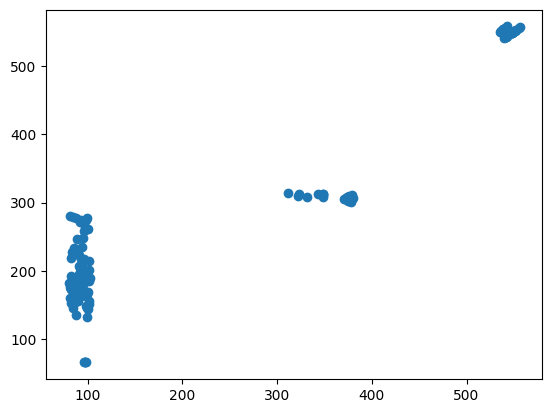

In [123]:
plt.scatter(data.loc[:, ['y']], data.loc[:, ['x']])

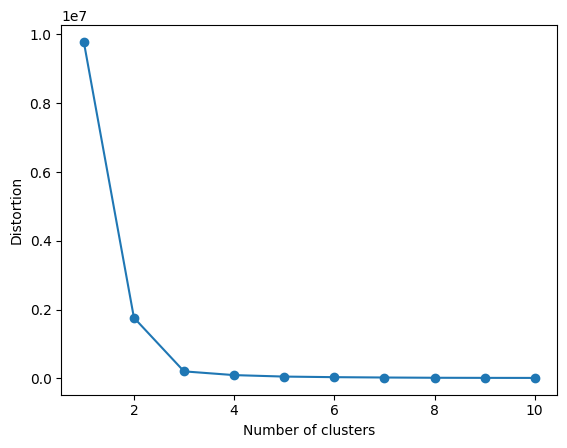

In [125]:
#elbow
distortions = []

for i in range(1,11):                 
    km = KMeans(n_clusters=i,
                init='k-means++',     
                n_init=10,
                max_iter=300,
                random_state=0)
    km.fit(data3)                        
    distortions.append(km.inertia_)   

plt.plot(range(1,11),distortions,marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [124]:
km = KMeans(n_clusters=3, random_state=42)
label = km.fit_predict(data2[:])

Text(364.1000000000001, 307.8333333333333, '1')

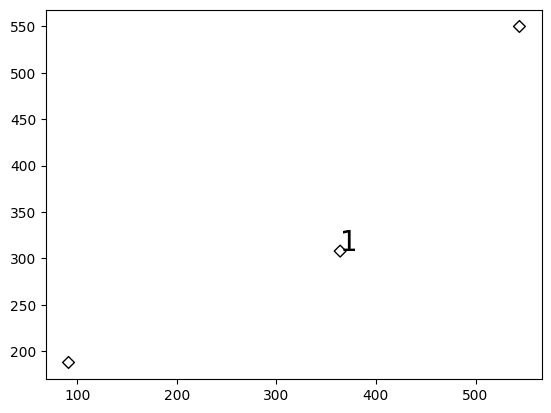

In [86]:
centers = km.cluster_centers_
plt.scatter(centers[:, 1], centers[:, 0], marker="D",
            facecolors='none', edgecolors='black')

plt.text(centers[0][1], centers[0][0], "1", fontsize=20)

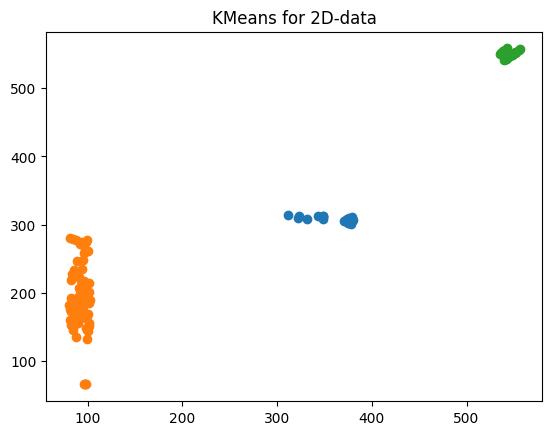

In [126]:
plt.scatter(data.loc[:, ['y']][label==0], data.loc[:, ['x']][label==0])
plt.scatter(data.loc[:, ['y']][label==1], data.loc[:, ['x']][label==1])
plt.scatter(data.loc[:, ['y']][label==2], data.loc[:, ['x']][label==2])
plt.title("KMeans for 2D-data")
plt.savefig("plot.png")
plt.show()

In [139]:
dd=data.loc[:, ['y']][label==0]
ddList = dd["y"].index.to_list()
ddList

In [143]:
obsList =[]
for i in ddList:
    obsList.append(interaction_array[i])

In [144]:
for i in ddList:
    obsList.append(interaction_with_array[i])

In [145]:
obsList

['working',
 'working',
 'working',
 'working',
 'working',
 'working',
 'working',
 'working',
 'working',
 'working',
 'working',
 'working',
 'working',
 'working',
 'working',
 'working',
 'working',
 'working',
 'working',
 'working',
 'working',
 'working',
 'working',
 'working',
 'working',
 'working',
 'working',
 'working',
 'working',
 'working',
 'keyboard',
 'keyboard',
 'keyboard',
 'keyboard',
 'keyboard',
 'keyboard',
 'keyboard',
 'keyboard',
 'keyboard',
 'keyboard',
 'keyboard',
 'keyboard',
 'keyboard',
 'keyboard',
 'keyboard',
 'keyboard',
 'keyboard',
 'keyboard',
 'keyboard',
 'keyboard',
 'keyboard',
 'keyboard',
 'keyboard',
 'keyboard',
 'keyboard',
 'keyboard',
 'keyboard',
 'keyboard',
 'keyboard',
 'keyboard']

In [40]:
from gensim.models import KeyedVectors
model_dir = 'wiki-news-300d-1M.vec'
model = KeyedVectors.load_word2vec_format(model_dir, binary=False)

In [46]:
utilizationClassList =['work','relax','dining','read','aisle']
score=[]
for utilization in utilizationClassList:
    similarityList=[]
    for observe in observedList:
        print(f'{utilization}:{observe} {model.similarity(utilization, observe)}')
        similarityList.append(model.similarity(utilization, observe))
    score.append(np.mean(similarityList))
print(score)

work:working 0.6682043075561523
work:working 0.6682043075561523
work:working 0.6682043075561523
work:working 0.6682043075561523
work:working 0.6682043075561523
work:working 0.6682043075561523
work:working 0.6682043075561523
work:working 0.6682043075561523
work:working 0.6682043075561523
work:working 0.6682043075561523
work:working 0.6682043075561523
work:working 0.6682043075561523
work:working 0.6682043075561523
work:working 0.6682043075561523
work:working 0.6682043075561523
work:working 0.6682043075561523
work:working 0.6682043075561523
work:working 0.6682043075561523
work:working 0.6682043075561523
work:working 0.6682043075561523
work:working 0.6682043075561523
work:working 0.6682043075561523
work:working 0.6682043075561523
work:working 0.6682043075561523
work:working 0.6682043075561523
work:working 0.6682043075561523
work:working 0.6682043075561523
work:working 0.6682043075561523
work:working 0.6682043075561523
work:working 0.6682043075561523
work:keyboard 0.3785247206687927
work:ke

In [146]:
similar_list = model.most_similar('work')
for similar_set in similar_list:
    print(str(similar_set[0])+ " : " + str(similar_set[1]))

works : 0.717581570148468
working : 0.6682043671607971
job : 0.6681519746780396
Work : 0.642331063747406
work. : 0.6332440972328186
research : 0.6295222640037537
work- : 0.6242907047271729
doing : 0.6225779056549072
effort : 0.6146255731582642
work-- : 0.6137425303459167


In [23]:
utilizationClassList =['work','relax','dining','read','aisle']
obsList=['working','keyboard']
score=[]
for uclass in utilizationClassList:
    exitList=[]
    for oclass in obsList:
        print(f'{uclass}:{oclass} {model.similarity(uclass, oclass)}')
        exitList.append(model.similarity(uclass, oclass))
    score.append(np.mean(exitList))
print(score)
#ここのスコアを観測クラスの数に応じて変化させる

# print(model.similarity('workspace', 'keyboard'))
# print(model.similarity('relax', 'cellphone'))
# print(model.similarity('dining', 'book'))

work:working 0.6682043075561523
work:keyboard 0.3785247206687927
relax:working 0.3584078848361969
relax:keyboard 0.22833183407783508
dining:working 0.39249739050865173
dining:keyboard 0.31231793761253357
read:working 0.35465922951698303
read:keyboard 0.21017998456954956
aisle:working 0.2026730328798294
aisle:keyboard 0.3111250698566437
[0.52336454, 0.29336986, 0.35240766, 0.28241962, 0.25689906]


In [87]:
max_value = max(score)
max_index = score.index(max_value)
print(max_index)

0


In [88]:
utilizationClassList[max_index]

'work'

Text(364.1000000000001, 307.8333333333333, 'work')

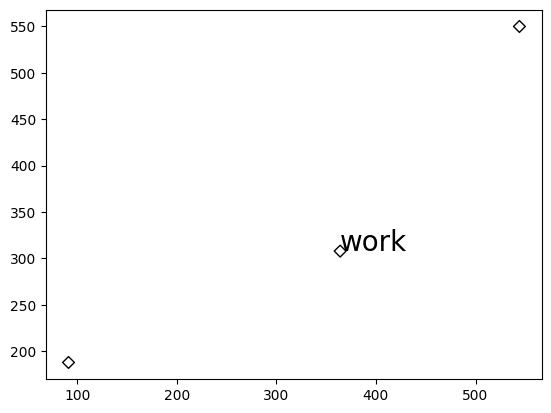

In [89]:
centers = km.cluster_centers_
plt.scatter(centers[:, 1], centers[:, 0], marker="D",
            facecolors='none', edgecolors='black')

plt.text(centers[0][1], centers[0][0], f"{utilizationClassList[max_index]}", fontsize=20)